In [135]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime, timedelta
import datetime
import pickle
import functools
import itertools
from collections import namedtuple
import os


# Initializing
sns.set()

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 10, 6

pd.set_option('display.max_columns', 150)

# Graphics in SVG format are more sharp and legible
%config InlineBackend.figure_format = 'svg'
%load_ext snakeviz
%matplotlib inline

The snakeviz extension is already loaded. To reload it, use:
  %reload_ext snakeviz


In [136]:
import json
import ijson

In [137]:
# path_to_zip_file = 'data/customers-20191025.jsonl.zip'
# directory_to_extract_to = 'data/customers'

In [4]:
# import zipfile
# with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
#     zip_ref.extractall(directory_to_extract_to)

In [5]:
customers_file = 'customers-20191025.jsonl'

In [6]:
customers_text = None
with open(customers_file) as f:
    customers_text = f.read()

In [7]:
customers_objects = [json.loads(jline) for jline in customers_text.split('\n')]

In [8]:
len(customers_objects)

320562

In [9]:
customers_objects[:1]

[{'OKPO': '99263437',
  'OKVED': '80.10.1',
  'accounts': {'account': [{'bankAddress': '456618, Челябинская область, г. Копейск, Коммунистический 16 а',
     'bankName': 'Копейский филиал ОАО «Челиндбанк» г. Копейск',
     'bik': '047501711',
     'corrAccount': '30101810400000000711',
     'paymentAccount': '40302810907285000006',
     'personalAccount': '05208024Р'},
    {'bankAddress': '454080 г Челябинск ул. Тернопольская 4',
     'bankName': 'Управление Федерального казначейства по Челябинской области',
     'bik': '047501001',
     'corrAccount': None,
     'paymentAccount': '40701810200001000012',
     'personalAccount': '20320800078ВР'}]},
  'actual': 'true',
  'allNames': ['Муниципальное дошкольное образовательное учреждение детский сад N 8 комбинированного вида второй категории Копейского городского округа',
   'Муниципальное дошкольное образовательное учреждение детский сад № 8 комбинированного вида Копейского городского округа'],
  'budgets': {'budget': {'code': '69030146',

In [56]:
columns = ['person_name', 'contracts_count', 'contracts_sum', 'region_code', 'max_year', 'min_year', 'agency',
          'factual_zip']
Row = namedtuple('Row', columns)

rows = []
count_ok = 0
count_err = 0
for cus in customers_objects:
    try:

        person = cus.get('contactPerson')
        row = Row(
            person_name=f'{person["lastName"]} {person["firstName"]} {person.get("middleName", "")}' if person else None,
            contracts_count=cus.get('contractsTotalCount', cus.get('contractsCount')),
            contracts_sum=cus.get('contractsTotalSum', cus.get('contractsSum')),
            region_code=cus.get('regionCode'),
            max_year=max([int(v) for v in cus['contractsYearStats'].keys()]) if cus.get('contractsYearStats') else None,
            min_year=min([int(v) for v in cus['contractsYearStats'].keys()]) if cus.get('contractsYearStats') else None,
            agency=cus['orderingAgency']['fullName'] if cus.get('orderingAgency') else None,
            factual_zip=cus['factualAddress'].get('zip') if cus.get('factualAddress') else None,
        )
        rows.append(row)
        count_ok+=1
    except Exception as e:
        print(e)
        count_err+=1
    if count_ok % 10000 == 0:
        print(count_ok)
#     print('tick')
count_ok, count_err

10000
20000
30000
40000
50000
60000
70000
80000
90000
'firstName'
'firstName'
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000
320000


(320560, 2)

In [57]:
cus

{'allNames': ['ГОСУДАРСТВЕННОЕ КАЗЕННОЕ УЧРЕЖДЕНИЕ "ЦЕНТР ПОДДЕРЖКИ МОЛОДЕЖНЫХ ИНИЦИАТИВ "ЗВЕЗДНЫЙ КАМПУС"'],
 'contractsCount': 1,
 'contractsSum': 54989.3,
 'contractsYearStats': {'2019': {'contractsCount': 1,
   'contractsSum': 54989.3}},
 'fullName': 'ГОСУДАРСТВЕННОЕ КАЗЕННОЕ УЧРЕЖДЕНИЕ "ЦЕНТР ПОДДЕРЖКИ МОЛОДЕЖНЫХ ИНИЦИАТИВ "ЗВЕЗДНЫЙ КАМПУС"',
 'inn': '9901037059',
 'kpp': '990101001',
 'regNumber': '08485000040',
 'regionCode': '99'}

In [72]:
df = pd.DataFrame(rows)
df.head()

person_name  contracts_count  contracts_sum  \
0        Вахрушева Фаина Дмитриевна               31   3.933875e+06   
1        Вахрушева Фаина Дмитриевна              234   3.334729e+07   
2           Буткова Дарья Сергеевна               12   3.121189e+06   
3        Сергеева Елена Анатольевна             1128   3.918467e+08   
4  Анисимов Александр Александрович                8   9.491766e+04   

  region_code  max_year  min_year  \
0          74    2013.0    2011.0   
1          74    2019.0    2014.0   
2          59    2013.0    2011.0   
3          59    2019.0    2014.0   
4          74    2012.0    2012.0   

                                              agency factual_zip  
0  Финансовое управление администрации Копейского...      456610  
1  ФИНАНСОВОЕ УПРАВЛЕНИЕ АДМИНИСТРАЦИИ КОПЕЙСКОГО...      456610  
2            Федеральная служба исполнения наказаний      618554  
3            ФЕДЕРАЛЬНАЯ СЛУЖБА ИСПОЛНЕНИЯ НАКАЗАНИЙ      614012  
4  Министерство сельского хозяйства Российской Фе...      456404

In [73]:
grouped_df = df.groupby(['person_name']).agg({'region_code': 'count', 'contracts_count': 'sum', 'contracts_sum': 'sum', 'min_year': 'min', 'max_year': 'max', 'agency': list})
grouped_df.head()

region_code  contracts_count  \
person_name                                                              
A A A                                               1              690   
Abdulfatahova Madina A                              1                0   
Abdulkadirov Saigidmagomed Suleimanovich            1                0   
Abdulkarimova Gulsina Hidijatovna                   1                1   
Abdullaev Abdulkerim A                              1                0   

                                          contracts_sum  min_year  max_year  \
person_name                                                                   
A A A                                      1.076667e+09    2010.0    2019.0   
Abdulfatahova Madina A                     0.000000e+00       NaN       NaN   
Abdulkadirov Saigidmagomed Suleimanovich   0.000000e+00       NaN       NaN   
Abdulkarimova Gulsina Hidijatovna          5.032130e+05    2014.0    2014.0   
Abdullaev Abdulkerim A                     0.000000e+00       NaN       NaN   

                                                                                     agency  
person_name                                                                                  
A A A                                     [МИНИСТЕРСТВО РОССИЙСКОЙ ФЕДЕРАЦИИ ПО ДЕЛАМ ГР...  
Abdulfatahova Madina A                    [АДМИНИСТРАЦИЯ МУНИЦИПАЛЬНОГО РАЙОНА "МАГАРАМК...  
Abdulkadirov Saigidmagomed Suleimanovich        [МИНИСТЕРСТВО ФИНАНСОВ РЕСПУБЛИКИ ДАГЕСТАН]  
Abdulkarimova Gulsina Hidijatovna         [ФИНАНСОВОЕ УПРАВЛЕНИЕ АДМИНИСТРАЦИИ МУНИЦИПАЛ...  
Abdullaev Abdulkerim A                    [АДМИНИСТРАЦИЯ МУНИЦИПАЛЬНОГО РАЙОНА "МАГАРАМК...

In [74]:
grouped_df['contracts_entries_count'] = grouped_df['region_code']
grouped_df.drop('region_code', axis=1, inplace=True)

In [75]:
grouped_df.shape

(250291, 6)

In [76]:
grouped_df[grouped_df.isnull().any(axis=1)].sample(5)

contracts_count  contracts_sum  min_year  \
person_name                                                                  
Кусаева Фатима Иссаевна                         0            0.0       NaN   
Абабков Павел Викторович                        0            0.0       NaN   
САРАКАЕВ МАХШАРИП УЗУМ-ХАДЖИЕВИЧ                1      4777500.0       NaN   
Яблокова Надежда Николаевна                     0            0.0       NaN   
Нальгиева Фасиман Султановна                    0            0.0       NaN   

                                  max_year  \
person_name                                  
Кусаева Фатима Иссаевна                NaN   
Абабков Павел Викторович               NaN   
САРАКАЕВ МАХШАРИП УЗУМ-ХАДЖИЕВИЧ       NaN   
Яблокова Надежда Николаевна            NaN   
Нальгиева Фасиман Султановна           NaN   

                                                                             agency  \
person_name                                                                           
Кусаева Фатима Иссаевна           [АДМИНИСТРАЦИЯ ЧЕРМЕНСКОГО СЕЛЬСКОГО ПОСЕЛЕНИЯ...   
Абабков Павел Викторович          [МИНИСТЕРСТВО ВНУТРЕННИХ ДЕЛ РОССИЙСКОЙ ФЕДЕРА...   
САРАКАЕВ МАХШАРИП УЗУМ-ХАДЖИЕВИЧ                                             [None]   
Яблокова Надежда Николаевна       [ФИНАНСОВОЕ УПРАВЛЕНИЕ АДМИНИСТРАЦИИ ОСТРОВСКО...   
Нальгиева Фасиман Султановна           [МИНИСТЕРСТВО ФИНАНСОВ РЕСПУБЛИКИ ИНГУШЕТИЯ]   

                                  entries_count  
person_name                                      
Кусаева Фатима Иссаевна                       1  
Абабков Павел Викторович                      1  
САРАКАЕВ МАХШАРИП УЗУМ-ХАДЖИЕВИЧ              1  
Яблокова Надежда Николаевна                   1  
Нальгиева Фасиман Султановна                  1

In [77]:
grouped_df = grouped_df[grouped_df.contracts_count != 0]
grouped_df.shape

(209900, 6)

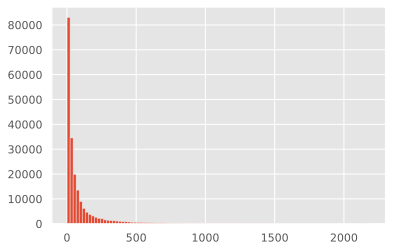

In [78]:
grouped_df.contracts_count[(grouped_df.contracts_count < grouped_df.contracts_count.quantile(0.99))].hist(bins=100)

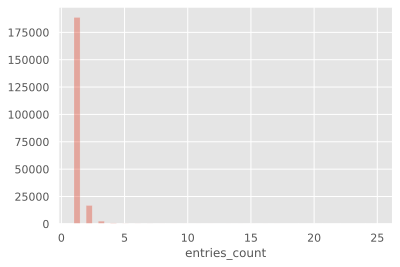

In [80]:
vcounts = grouped_df.entries_count
vcounts = vcounts[vcounts < vcounts.quantile(0.999)]

sns.distplot(vcounts, kde=False)

In [81]:
grouped_df.drop(['agency'], axis=1, inplace=True)

In [88]:
grouped_df.head()

contracts_count  contracts_sum  min_year  \
person_name                                                                   
A A A                                          690   1.076667e+09    2010.0   
Abdulkarimova Gulsina Hidijatovna                1   5.032130e+05    2014.0   
Abdunasirov Magomed Ahmedovich                  10   8.572522e+06    2012.0   
Adamski Michail Ykovlevich                     370   1.005988e+08    2010.0   
Adiev Abduraschid A                              5   4.464164e+06    2012.0   

                                   max_year  entries_count  
person_name                                                 
A A A                                2019.0              1  
Abdulkarimova Gulsina Hidijatovna    2014.0              1  
Abdunasirov Magomed Ahmedovich       2014.0              1  
Adamski Michail Ykovlevich           2019.0              1  
Adiev Abduraschid A                  2015.0              1

In [82]:
grouped_df.to_csv('person_contracts.csv')

# Attempt join

In [83]:
df1 = pd.read_csv('yearly_incomes_in_real_estate.csv')
df1.head()

person_id                  person_name        income  real_estate_price  \
0          8   Зюганов Геннадий Андреевич  3.252324e+06       2.390986e+07   
1          9       Алферов Жорес Иванович  1.458084e+07       9.951926e+08   
2         10   Андреев Андрей Анатольевич  3.615634e+06       4.880553e+07   
3         11  Апарина Алевтина Викторовна  2.102010e+06       6.026755e+06   
4         12     Афонин Юрий Вячеславович  6.420679e+06       1.223309e+08   

   yearly_incomes_in_real_estate  
0                       7.351622  
1                      68.253432  
2                      13.498469  
3                       2.867139  
4                      19.052638

In [91]:
df1['person_name'] = df1['person_name'].str.lower()

In [92]:
df1.shape

(51909, 5)

In [99]:
grouped_df = grouped_df.reset_index()

In [100]:
grouped_df['person_name'] = grouped_df['person_name'].str.lower() 

In [101]:
grouped_df.head()

person_name  contracts_count  contracts_sum  \
0                              a a a              690   1.076667e+09   
1  abdulkarimova gulsina hidijatovna                1   5.032130e+05   
2     abdunasirov magomed ahmedovich               10   8.572522e+06   
3         adamski michail ykovlevich              370   1.005988e+08   
4                adiev abduraschid a                5   4.464164e+06   

   min_year  max_year  entries_count  
0    2010.0    2019.0              1  
1    2014.0    2014.0              1  
2    2012.0    2014.0              1  
3    2010.0    2019.0              1  
4    2012.0    2015.0              1

In [105]:
merged_df = pd.merge(df1, grouped_df, on='person_name', how='left')
merged_df.shape

(52188, 10)

In [106]:
merged_df.head().T

0  \
person_id                                               8   
person_name                    зюганов геннадий андреевич   
income                                        3.25232e+06   
real_estate_price                             2.39099e+07   
yearly_incomes_in_real_estate                     7.35162   
contracts_count                                       NaN   
contracts_sum                                         NaN   
min_year                                              NaN   
max_year                                              NaN   
entries_count                                         NaN   

                                                    1  \
person_id                                           9   
person_name                    алферов жорес иванович   
income                                    1.45808e+07   
real_estate_price                         9.95193e+08   
yearly_incomes_in_real_estate                 68.2534   
contracts_count                                   NaN   
contracts_sum                                     NaN   
min_year                                          NaN   
max_year                                          NaN   
entries_count                                     NaN   

                                                        2  \
person_id                                              10   
person_name                    андреев андрей анатольевич   
income                                        3.61563e+06   
real_estate_price                             4.88055e+07   
yearly_incomes_in_real_estate                     13.4985   
contracts_count                                        12   
contracts_sum                                 3.40643e+06   
min_year                                             2010   
max_year                                             2019   
entries_count                                           2   

                                                         3  \
person_id                                               11   
person_name                    апарина алевтина викторовна   
income                                         2.10201e+06   
real_estate_price                              6.02676e+06   
yearly_incomes_in_real_estate                      2.86714   
contracts_count                                        NaN   
contracts_sum                                          NaN   
min_year                                               NaN   
max_year                                               NaN   
entries_count                                          NaN   

                                                      4  
person_id                                            12  
person_name                    афонин юрий вячеславович  
income                                      6.42068e+06  
real_estate_price                           1.22331e+08  
yearly_incomes_in_real_estate                   19.0526  
contracts_count                                     NaN  
contracts_sum                                       NaN  
min_year                                            NaN  
max_year                                            NaN  
entries_count                                       NaN

In [108]:
merged_df.sample(10)

person_id                       person_name        income  \
28720      28982      кожушный денис александрович  1.062491e+06   
22905      23173             заика олег викторович  1.488336e+06   
37535      37783     астахов александр геннадьевич  1.436764e+06   
17190      17434         утешев виталий викторович  2.676068e+06   
32274      32526       бубнов алексей владимирович  1.197061e+06   
45172      45436  дороничева светлана владимировна  4.258151e+06   
31269      31516           земцова анна михайловна  4.599721e+05   
42852      43131         пономарева ольга ивановна  1.592298e+06   
32393      32645     павлов геннадий александрович  8.074966e+05   
15713      15964         ильиных сергей евгеньевич  2.525461e+06   

       real_estate_price  yearly_incomes_in_real_estate  contracts_count  \
28720       2.067820e+08                     194.619886              NaN   
22905       1.252330e+07                       8.414295              NaN   
37535       4.914004e+06                       3.420188              NaN   
17190       1.558414e+08                      58.235220              NaN   
32274       8.752617e+06                       7.311753              NaN   
45172       1.609242e+07                       3.779205            417.0   
31269       7.800125e+06                      16.957822              NaN   
42852       9.485079e+06                       5.956848              NaN   
32393       6.184967e+06                       7.659434              NaN   
15713       3.572057e+07                      14.144180              NaN   

       contracts_sum  min_year  max_year  entries_count  
28720            NaN       NaN       NaN            NaN  
22905            NaN       NaN       NaN            NaN  
37535            NaN       NaN       NaN            NaN  
17190            NaN       NaN       NaN            NaN  
32274            NaN       NaN       NaN            NaN  
45172   5.773369e+08    2011.0    2019.0            3.0  
31269            NaN       NaN       NaN            NaN  
42852            NaN       NaN       NaN            NaN  
32393            NaN       NaN       NaN            NaN  
15713            NaN       NaN       NaN            NaN

In [115]:
clean_merged

person_id                  person_name        income  \
0              8   зюганов геннадий андреевич  3.252324e+06   
1              9       алферов жорес иванович  1.458084e+07   
2             10   андреев андрей анатольевич  3.615634e+06   
3             11  апарина алевтина викторовна  2.102010e+06   
4             12     афонин юрий вячеславович  6.420679e+06   
...          ...                          ...           ...   
52183      52414    панина лариса геннадьевна  9.121717e+05   
52184      52415   малышева евгения борисовна  1.546768e+06   
52185      52416               луконкина в.и   5.153431e+06   
52186      52417                  янущик д.и   3.786760e+06   
52187      52418                  павлов г.д   4.388519e+06   

       real_estate_price  yearly_incomes_in_real_estate  contracts_count  \
0           2.390986e+07                       7.351622              NaN   
1           9.951926e+08                      68.253432              NaN   
2           4.880553e+07                      13.498469             12.0   
3           6.026755e+06                       2.867139              NaN   
4           1.223309e+08                      19.052638              NaN   
...                  ...                            ...              ...   
52183       2.359377e+07                      25.865497              NaN   
52184       1.650906e+08                     106.732578              NaN   
52185       9.878120e+07                      19.168046              NaN   
52186       1.831220e+08                      48.358479              NaN   
52187       1.389551e+07                       3.166333              NaN   

       contracts_sum  min_year  max_year  entries_count  
0                NaN       NaN       NaN            NaN  
1                NaN       NaN       NaN            NaN  
2         3406433.29    2010.0    2019.0            2.0  
3                NaN       NaN       NaN            NaN  
4                NaN       NaN       NaN            NaN  
...              ...       ...       ...            ...  
52183            NaN       NaN       NaN            NaN  
52184            NaN       NaN       NaN            NaN  
52185            NaN       NaN       NaN            NaN  
52186            NaN       NaN       NaN            NaN  
52187            NaN       NaN       NaN            NaN  

[51666 rows x 10 columns]

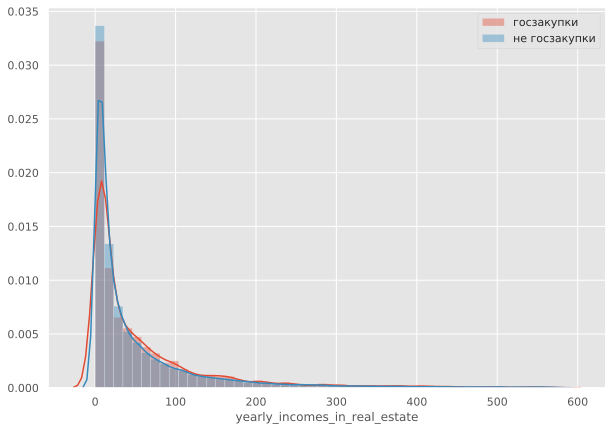

In [131]:
clean_merged = merged_df[merged_df.yearly_incomes_in_real_estate < merged_df.yearly_incomes_in_real_estate.quantile(0.96)]
plt.figure(figsize=(10, 7))
sns.distplot(clean_merged[clean_merged.entries_count > 0].yearly_incomes_in_real_estate, label='госзакупки', kde=True)
sns.distplot(clean_merged[clean_merged.entries_count.isnull()].yearly_incomes_in_real_estate, label='не госзакупки', kde=True)
plt.legend()
plt.show()